Analyses properties of decorrelation and whitening methods for FC and Convolutional cases.

In [1]:
import numpy as np
import torch
from decorrelation.decorrelation import lower_triangular, Decorrelation, DecorConv2d # DecorrelationPatch2d # covariance, DecorrelationPatch2d, DecorrelationFC, lower_triangular
from decorrelation.plotting import *

# automatic reloading of modules when they change
%load_ext autoreload
%autoreload 2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
def decorrelate(num_epochs, data, model, decor_lr):

    # covariance matrix before training
    X = model.decorrelate(data).view(data.shape[0],-1)
    A1 = (X.T @ X) / len(X)

    # train decorrelator
    L = np.zeros(num_epochs)
    for i in range(num_epochs):
        model.forward(data)
        L[i] = model.update()
        model.weight -= decor_lr * model.weight.grad
        if model.bias is not None:
            model.bias -= decor_lr * model.bias.grad
        
        print(f'iteration {i}\tloss: {L[i]:.3f}')

    # covariance matrix after training
    X = model.decorrelate(data).view(data.shape[0],-1)
    A2 = (X.T @ X) / len(X)

    return L, A1, A2

We start by showing effective decorrelation of correlated input

In [3]:
num_samples=1000
num_features=100
num_epochs=2000
seed=42
decor_lr=1e1
kappa=1e-1

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

# generate correlated data
d = torch.distributions.MultivariateNormal(torch.zeros(num_features), 0.8 * torch.eye(num_features) + 0.2 * torch.ones((num_features, num_features)))
data = d.sample((num_samples,)).to(device)

# create a decorrelator
model = Decorrelation(in_features=num_features, bias=False, kappa=kappa).to(device)

L, A1, A2 = decorrelate(num_epochs, data, model, decor_lr)


iteration 0	loss: 0.187
iteration 1	loss: 0.183
iteration 2	loss: 0.179
iteration 3	loss: 0.175
iteration 4	loss: 0.172
iteration 5	loss: 0.168
iteration 6	loss: 0.165
iteration 7	loss: 0.162
iteration 8	loss: 0.159
iteration 9	loss: 0.156
iteration 10	loss: 0.153
iteration 11	loss: 0.151
iteration 12	loss: 0.148
iteration 13	loss: 0.145
iteration 14	loss: 0.143
iteration 15	loss: 0.141
iteration 16	loss: 0.139
iteration 17	loss: 0.136
iteration 18	loss: 0.134
iteration 19	loss: 0.132
iteration 20	loss: 0.130
iteration 21	loss: 0.128
iteration 22	loss: 0.127
iteration 23	loss: 0.125
iteration 24	loss: 0.123
iteration 25	loss: 0.121
iteration 26	loss: 0.120
iteration 27	loss: 0.118
iteration 28	loss: 0.117
iteration 29	loss: 0.115
iteration 30	loss: 0.114
iteration 31	loss: 0.112
iteration 32	loss: 0.111
iteration 33	loss: 0.109
iteration 34	loss: 0.108
iteration 35	loss: 0.107
iteration 36	loss: 0.106
iteration 37	loss: 0.104
iteration 38	loss: 0.103
iteration 39	loss: 0.102
iteration 

mean variance: 0.92


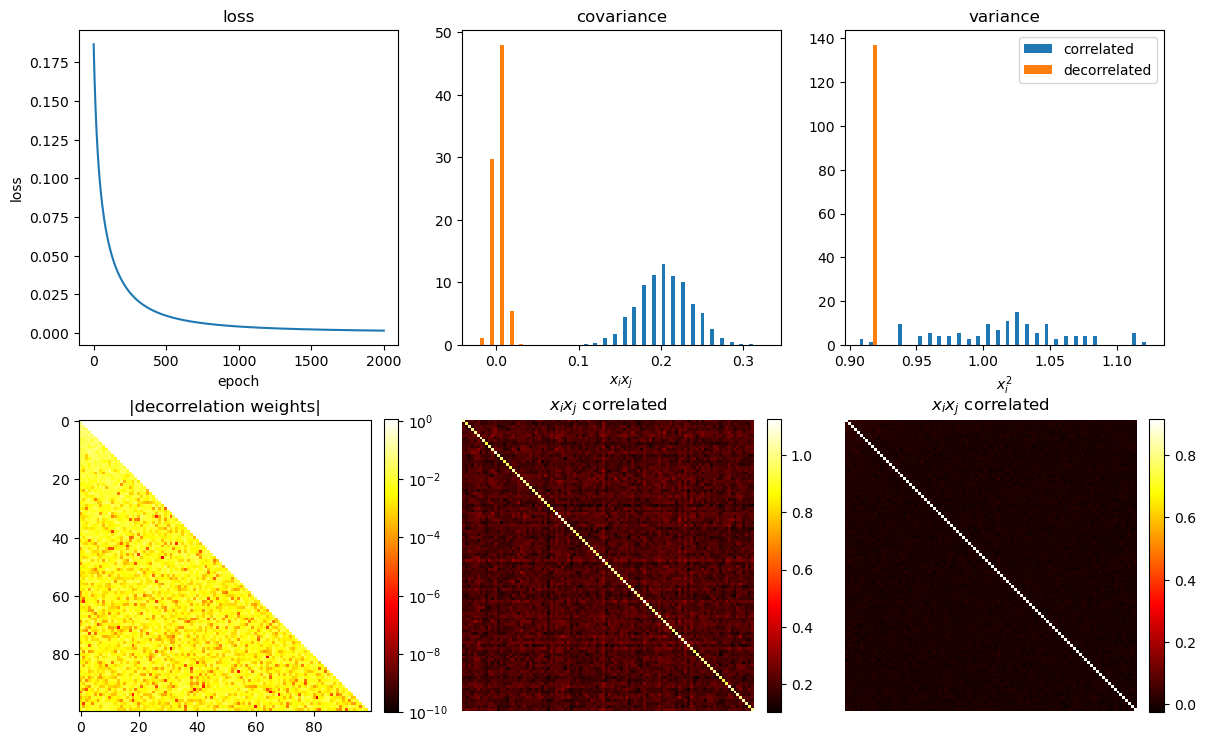

In [4]:
plot_decorrelation_results(model, L, A1, A2)
print(f'mean variance: {torch.mean(torch.diag(A2)):.2f}')

Decorrelation of correlated input using DecorConv2d

In [5]:
# generate [N, M] correlated input
num_examples=1000
in_channels=2
out_channels=3
height=10
width=10
kernel_size=(3,3)
num_samples=1000
num_epochs=1000
seed=42
decor_lr=1e-1
kappa=1e-1
downsample_perc=0.1

num_features=in_channels*height*width
size = in_channels * np.prod(kernel_size)

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

d = torch.distributions.MultivariateNormal(torch.zeros(num_features), 0.1 * torch.eye(num_features) + 0.9 * torch.ones((num_features, num_features)))
data = d.sample((num_examples,)).reshape(num_examples,in_channels,height,width).to(device)

# create a convolutional decorrelator
# NOTE: how many samples for effective input decorrelation? Dependence on dim?
# nr of samples instead of perc?
# NOTE: version for immediate non-batched decorrelation...
model = DecorConv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, bias=False, kappa=kappa, downsample_perc=downsample_perc).to(device)

L, A1, A2 = decorrelate(num_epochs, data, model, decor_lr) 


iteration 0	loss: 0.881
iteration 1	loss: 0.719
iteration 2	loss: 0.712
iteration 3	loss: 0.772
iteration 4	loss: 0.616
iteration 5	loss: 0.755
iteration 6	loss: 0.607
iteration 7	loss: 0.725
iteration 8	loss: 0.872
iteration 9	loss: 0.708
iteration 10	loss: 0.742
iteration 11	loss: 0.702
iteration 12	loss: 0.658
iteration 13	loss: 0.651
iteration 14	loss: 0.736
iteration 15	loss: 0.681
iteration 16	loss: 0.814
iteration 17	loss: 0.688
iteration 18	loss: 0.750
iteration 19	loss: 0.664
iteration 20	loss: 0.773
iteration 21	loss: 0.616
iteration 22	loss: 0.681
iteration 23	loss: 0.924
iteration 24	loss: 0.680
iteration 25	loss: 0.773
iteration 26	loss: 0.560
iteration 27	loss: 0.710
iteration 28	loss: 0.727
iteration 29	loss: 0.570
iteration 30	loss: 0.727
iteration 31	loss: 0.716
iteration 32	loss: 0.752
iteration 33	loss: 0.626
iteration 34	loss: 0.750
iteration 35	loss: 0.546
iteration 36	loss: 0.754
iteration 37	loss: 0.631
iteration 38	loss: 0.783
iteration 39	loss: 0.646
iteration 

mean variance: 0.36


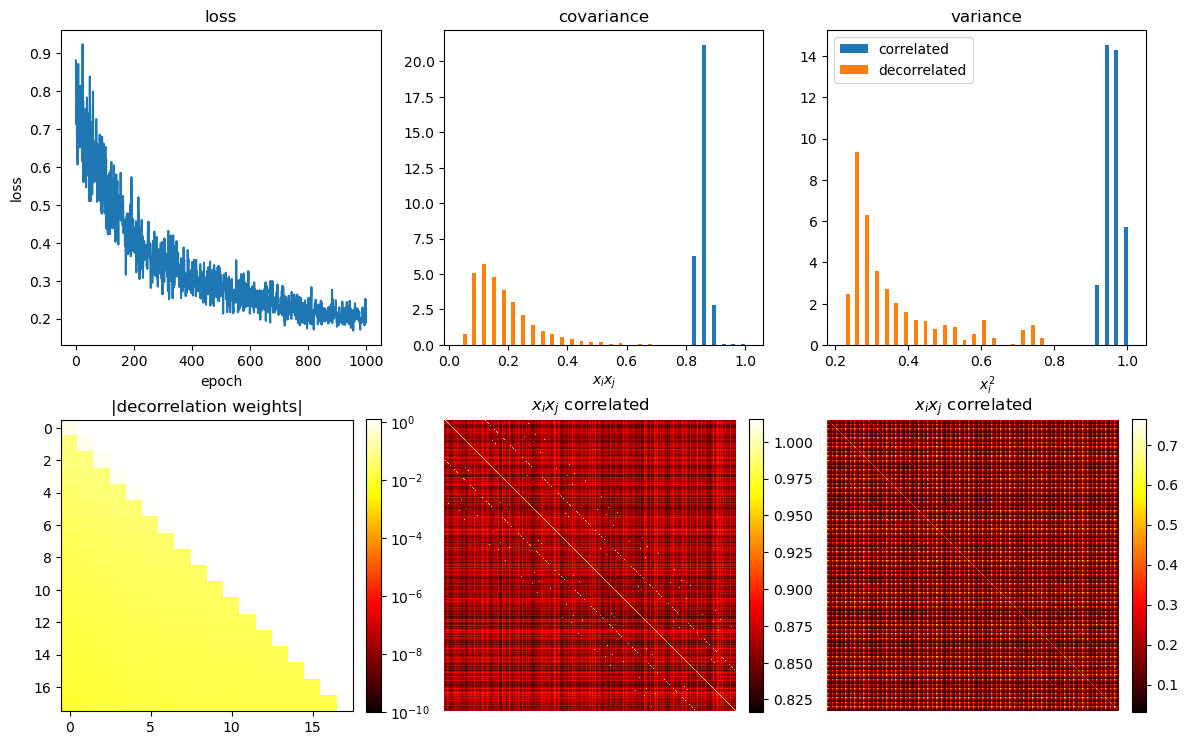

In [6]:
plot_decorrelation_results(model, L, A1, A2)
print(f'mean variance: {torch.mean(torch.diag(A2)):.2f}')